# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0

from fastai.vision import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 16   #number of workers for data loader
torch.cuda.set_device(1)
torch.backends.cudnn.benchmark=True
np.random.seed(42)

sz = 96
bs = 128

# Data 

In [2]:
data = (ImageItemList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
.random_split_by_pct(0.2)
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(get_transforms(flip_vert=True), size=sz)
.databunch(bs=bs, num_workers=nw)
.normalize(imagenet_stats))

In [3]:
#data.show_batch()

# Metrics 

In [4]:
def roc_curve_custom(y_pred:torch.Tensor, y_true:torch.Tensor):
    probs = y_pred[:,-1]
    fpr, tpr, thresholds = roc_curve(y_true, probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def auc_custom(y_pred:torch.Tensor, y_true:torch.Tensor):
    fpr, tpr, thresholds, roc_auc = roc_curve_custom(y_pred, y_true)
    return torch.as_tensor(roc_auc)

# Learner

## Create

In [5]:
arch = torchvision.models.resnet50

In [6]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     metrics=[accuracy, auc_custom])

## Train

### Multiple cycles

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


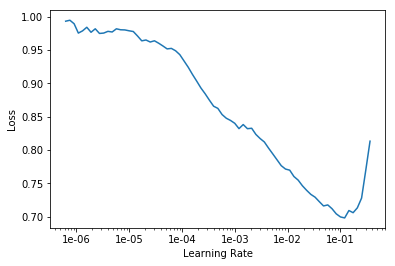

In [6]:
learner.recorder.plot()

In [11]:
lr = 1e-2
cycle_len_head=5

In [ ]:
learner.fit_one_cycle(cycle_len_head, slice(lr))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.save(f'{arch.__name__}-head')

In [6]:
learner.load('resnet50-head')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

In [7]:
learner.unfreeze()

In [8]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


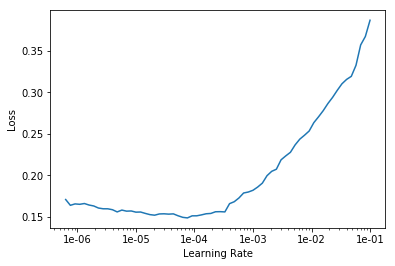

In [9]:
learner.recorder.plot()

In [20]:
lr2 = 1e-5

In [12]:
learner.fit_one_cycle(cyc_len=1, max_lr=slice(lr2, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.149396,0.119367,0.957096


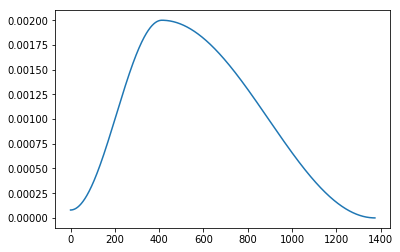

In [13]:
learner.recorder.plot_lr()

In [14]:
learner.save(f'{arch.__name__}-complete-1')

epoch,train_loss,valid_loss,accuracy
1,0.151710,0.132558,0.950710
2,0.117313,0.103587,0.963004


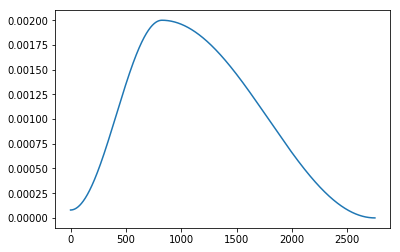

In [15]:
learner.fit_one_cycle(cyc_len=2, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-2')

epoch,train_loss,valid_loss,accuracy
1,0.139794,0.119252,0.957255
2,0.125170,0.115113,0.958164
3,0.107394,0.092442,0.967322
4,0.090649,0.090092,0.968890


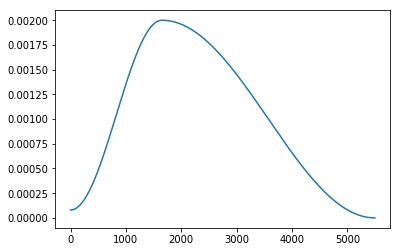

In [17]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-3')

epoch,train_loss,valid_loss,accuracy
1,0.108450,0.097394,0.965458
2,0.116108,0.106072,0.963095
3,0.112058,0.100635,0.964186
4,0.086022,0.084450,0.970912
5,0.082883,0.081713,0.970912
6,0.069958,0.077234,0.972321


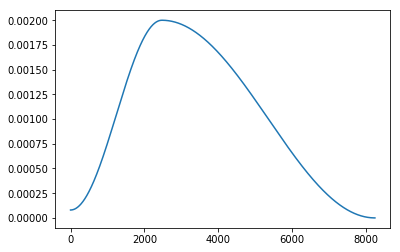

In [19]:
learner.fit_one_cycle(cyc_len=6, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-4')

epoch,train_loss,valid_loss,accuracy
1,0.072122,0.080197,0.971321
2,0.076660,0.087566,0.972162
3,0.077762,0.078887,0.972776
4,0.070409,0.076694,0.973139
5,0.070783,0.073485,0.974957
6,0.068790,0.072949,0.974435
7,0.067622,0.073835,0.974094
8,0.057429,0.073932,0.974026


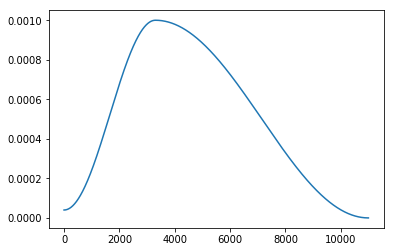

In [21]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/10, lr/10))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-5')

epoch,train_loss,valid_loss,accuracy
1,0.061565,0.073237,0.974798
2,0.058475,0.073333,0.974253
3,0.058036,0.073755,0.974412
4,0.064055,0.073075,0.974707
5,0.059303,0.071938,0.975116
6,0.061731,0.072562,0.975253
7,0.061684,0.072375,0.974912
8,0.056020,0.073141,0.974412


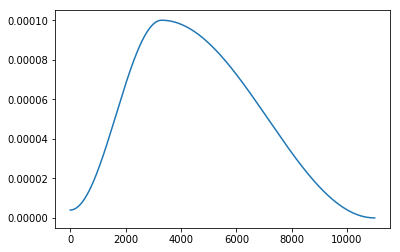

In [22]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/100, lr/100))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-6')

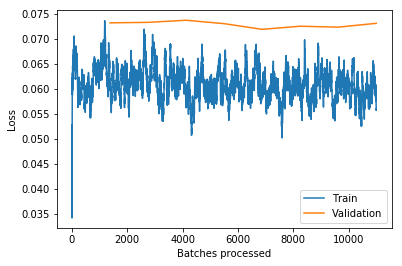

In [23]:
learner.recorder.plot_losses()

### One long cycle

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


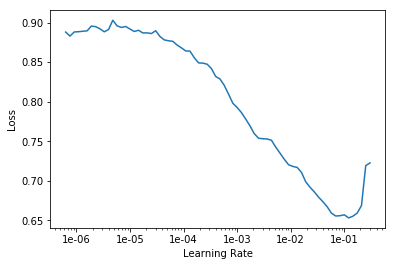

In [6]:
learner.recorder.plot()

In [6]:
lr = 1e-2

In [40]:
learner.fit_one_cycle(cyc_len=3, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy,auc_custom


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 11.91 GiB total capacity; 922.72 MiB already allocated; 72.56 MiB free; 142.15 MiB cached)

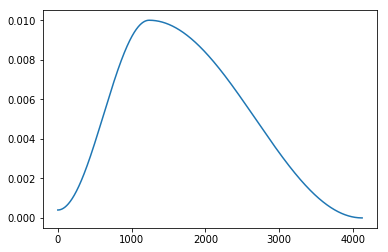

In [9]:
learner.recorder.plot_lr()

In [10]:
learner.save(f'{arch.__name__}-head-2')

In [5]:
learner.load(f'{arch.__name__}-head-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

In [7]:
learner.unfreeze()

In [12]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


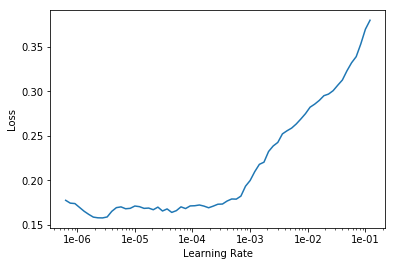

In [13]:
learner.recorder.plot()

In [11]:
lr2 = 1e-5

In [12]:
learner.fit_one_cycle(cyc_len=15, max_lr=slice(lr2, lr/10))

epoch,train_loss,valid_loss,accuracy
1,0.164653,0.141768,0.947256
2,0.161425,0.137965,0.948892
3,0.158322,0.133281,0.951574
4,0.142234,0.113947,0.959050
5,0.131024,0.127498,0.953028
6,0.127392,0.110383,0.959596
7,0.112007,0.100299,0.964368
8,0.097912,0.091642,0.967254
9,0.093059,0.093940,0.967254
10,0.088138,0.088342,0.969344


In [13]:
learner.save(f'{arch.__name__}-complete-2.1')

## Load

In [7]:
learner.load('resnet50_cycle_len=20-complete')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

# Interpretation

In [8]:
interp = ClassificationInterpretation.from_learner(learner)

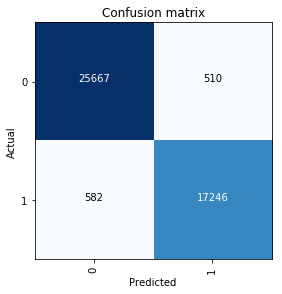

In [9]:
interp.plot_confusion_matrix()

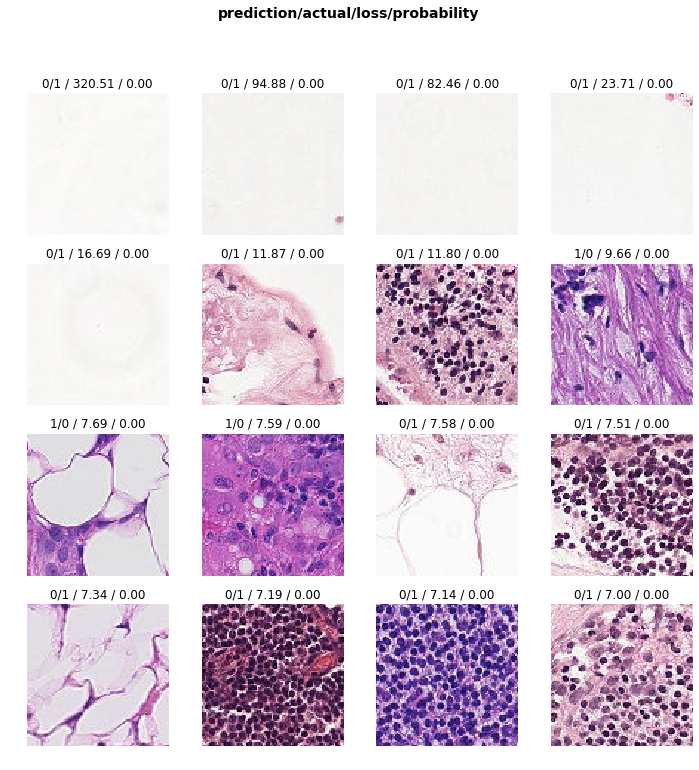

In [10]:
interp.plot_top_losses(16)

# ROC curve and AUC on validation set

In [11]:
preds_val, targets_val = learner.get_preds(ds_type=DatasetType.Valid)

In [12]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds_val, targets_val)

In [13]:
roc_auc

0.9958351618028729

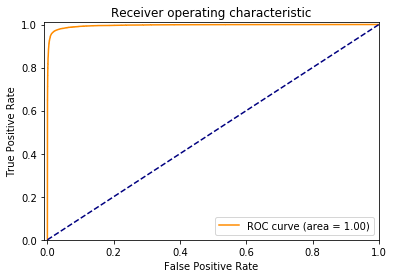

In [14]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Predictions

In [15]:
preds, _ = learner.TTA(ds_type=DatasetType.Test)
#preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [28]:
probs = np.array(preds[:,-1])

In [29]:
probs[0]

0.60866135

In [65]:
th = 0.2

In [66]:
pred_labels = np.where(probs > th, 1, 0)

In [67]:
#pred_labels = []
#for p in tqdm(np.array(preds)):
#    if p[0] > p[1]:
#        pred_labels.append(0)
#    if p[0] < p[1]:
#        pred_labels.append(1)
#    if p[0] == p[1]:
#        pred_labels.append(1)
#        print('same')

In [68]:
df = pd.DataFrame({'id':[fname.split('.')[0] for fname in os.listdir(TEST)], 'label':pred_labels})

In [69]:
name = f'13-{arch.__name__}_sz{sz}_bs{bs}_th{th}.csv'

In [70]:
df.to_csv(SUBMISSIONS/name, header=True, index=False)